In [3]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, anderson
from scipy.stats import norm
import math

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [4]:
competitions = sb.competitions()
fifa_2022 = sb.matches(competition_id=43, season_id=106)

In [5]:
#Grouped events
events_fifa = sb.competition_events(
    country="International",
    division='FIFA World Cup',
    season="2022",
    gender="male"
)

#Get the pass and shot variables
def get_pass_df(events_fifa):
    pass_vars = [col for col in events_fifa.columns if col.startswith('pass_')]
    
    #Create the pass and shot df
    pass_df = events_fifa[pass_vars]
    return pass_df

In [6]:
pass_df = get_pass_df(events_fifa) 

In [7]:
pass_df.head(2)

,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,...,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Risk

In [8]:
print('Number of total events: ' + str(len(pass_df)) + 
      '\nNumber of NaN in Outcome variable: '  + str(pass_df['pass_outcome'].isna().sum()) +
      '\nNumber of non empty rows: ' + str(len(pass_df) - pass_df['pass_outcome'].isna().sum()))

Number of total events: 234652
Number of NaN in Outcome variable: 222483
Number of non empty rows: 12169


In [9]:
#pass_df[['pass_outcome']].to_excel('pass_df.xlsx')

In [10]:
#Get the df only with completed Outcome vars
pass_df_notna = pass_df[pass_df['pass_outcome'].notna()]
pass_df_notna.shape

(12169, 23)

In [11]:
pass_df_risk = pass_df_notna[['pass_outcome', 'pass_length','pass_angle', 'pass_end_location' , 'pass_height', 'pass_body_part']]
pass_df_risk.reset_index(drop=True, inplace=True)

risk_df = pass_df_risk.iloc[:, :1]

pass_df_risk = pass_df_risk.iloc[:, 1:]
pass_df_risk.head(2)

,pass_length,pass_angle,pass_end_location,pass_height,pass_body_part
0,25.513134,-1.476588,"[108.0, 49.0]",Ground Pass,Right Foot
1,41.725890,-1.026678,"[99.3, 0.2]",High Pass,Right Foot


One-Hot Encoding

In [12]:
#One Hot Encoding
categorical_cols = ['pass_height', 'pass_body_part']

encoded_pass_df_risk = pd.get_dummies(pass_df_risk , columns= categorical_cols)

encoded_pass_df_risk.shape
encoded_pass_df_risk.head(2)

,pass_length,pass_angle,pass_end_location,pass_height_Ground Pass,pass_height_High Pass,pass_height_Low Pass,pass_body_part_Drop Kick,pass_body_part_Head,pass_body_part_Keeper Arm,pass_body_part_Left Foot,pass_body_part_No Touch,pass_body_part_Other,pass_body_part_Right Foot
0,25.513134,-1.476588,"[108.0, 49.0]",1,0,0,0,0,0,0,0,0,1
1,41.725890,-1.026678,"[99.3, 0.2]",0,1,0,0,0,0,0,0,0,1


Benefit 

In [13]:
pass_df_notna_1 = pass_df[pass_df['pass_goal_assist'].notna()]
pass_df_notna_2 = pass_df[pass_df['pass_shot_assist'].notna()]

pass_df_notna_assist = pd.concat([pass_df_notna_1 , pass_df_notna_2] , ignore_index=True)
pass_df_notna_assist.shape

(1039, 23)

In [14]:
pass_df_notna_assist.head(2)

,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,...,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type
0,NaN,1.438245,c7c1917b-2c74-40a4-94a0-dc7a9137a766,Right Foot,NaN,NaN,NaN,"[108.0, 52.0]",True,Ground Pass,...,NaN,NaN,NaN,Xherdan Shaqiri,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.249046,e90ac0da-ac09-4a22-a26e-01ff53f52434,Left Foot,True,NaN,NaN,"[108.3, 38.6]",True,High Pass,...,NaN,NaN,NaN,Aleksandar Mitrović,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
pass_df_ben = pass_df_notna_assist[['pass_goal_assist','pass_shot_assist' , 'pass_length','pass_angle', 'pass_end_location' , 'pass_height', 'pass_body_part']]
pass_df_ben.reset_index(drop=True, inplace=True)

ben_df = pass_df_ben.iloc[:, :2]

pass_df_ben = pass_df_ben.iloc[:, 2:]
pass_df_ben.head(2)

,pass_length,pass_angle,pass_end_location,pass_height,pass_body_part
0,7.566373,1.438245,"[108.0, 52.0]",Ground Pass,Right Foot
1,24.981993,1.249046,"[108.3, 38.6]",High Pass,Left Foot


In [16]:
pass_df_risk.describe()

,pass_length,pass_angle
count,12169.000000,12169.000000
mean,28.404491,-0.013221
std,21.240618,1.032950
min,0.000000,-3.126669
25%,11.183022,-0.620250
50%,23.668545,-0.010135
75%,41.276870,0.572030
max,114.512054,3.141593


Distribution of Explanatory Variables

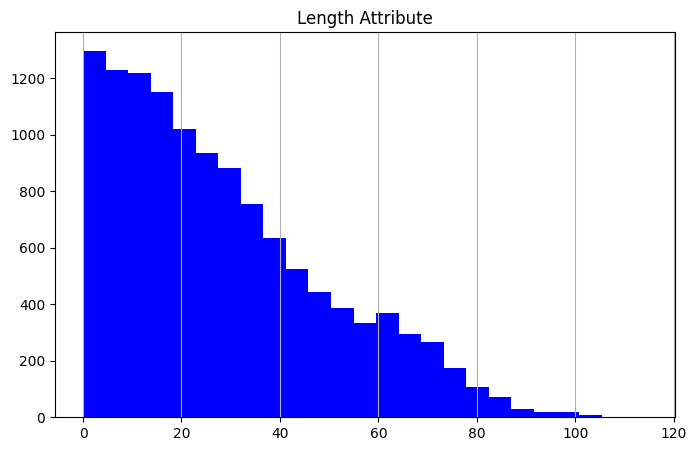

In [17]:
pass_df_risk['pass_length'].hist(bins= 25 ,figsize=(8, 5), color='blue', legend=False)
plt.grid(axis='y')
plt.title('Length Attribute')
#plt.savefig(f'histogram_pass_length.png', bbox_inches='tight')
plt.show()

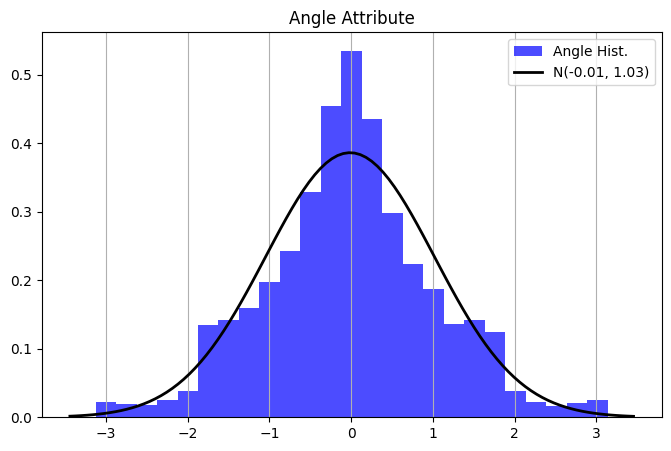

In [18]:
#Fit Normal distribution in angle histogram


# Create histogram
pass_df_risk['pass_angle'].hist( bins=25, figsize=(8, 5), density=True, alpha=0.7, color='blue', label='Angle Hist.')

# Fit a normal distribution to the data
mu, std = norm.fit(pass_df_risk['pass_angle'])

# Plot the PDF of the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'N({mu:.2f}, {std:.2f})')

# Add labels and a legend
plt.legend()
plt.grid(axis='y')

plt.title('Angle Attribute')
plt.savefig(f'histogram_pass_angle.png', bbox_inches='tight')

plt.show()

In [17]:
#Check for normality Shapiro-Wilk Test
stat, p_value = shapiro(pass_df_risk['pass_angle'])
print(f'Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}')

Shapiro-Wilk Test: Statistic=0.9935751557350159, p-value=6.96153592986204e-23


In [18]:
pass_df

,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,...,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
